In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
bkgtrees = ObjIter([Tree(fc.eightb.preselection.Bkg_MC_List)])

In [3]:
signaltrees = ObjIter([ Tree(f) for f in fc.eightb.preselection.signal_list ])

In [4]:
for tree in signaltrees: tree.color=None

In [69]:
trees = signaltrees + bkgtrees

In [70]:
trees.extend(kwargs=lambda t : build_collection(t,'H\dY\d','higgs',ptordered=True))

In [71]:
def calc_m_asym(tree):
    higgs_m = tree.higgs_m.to_numpy()
    higgs_m.sort(axis=-1)
    hm12_asym = (higgs_m[:,3]-higgs_m[:,2])/(higgs_m[:,3]+higgs_m[:,2])
    hm13_asym = (higgs_m[:,3]-higgs_m[:,1])/(higgs_m[:,3]+higgs_m[:,1])
    hm14_asym = (higgs_m[:,3]-higgs_m[:,0])/(higgs_m[:,3]+higgs_m[:,0])
    
    hm23_asym = (higgs_m[:,2]-higgs_m[:,1])/(higgs_m[:,2]+higgs_m[:,1])
    hm24_asym = (higgs_m[:,2]-higgs_m[:,0])/(higgs_m[:,2]+higgs_m[:,0])
    
    hm34_asym = (higgs_m[:,1]-higgs_m[:,0])/(higgs_m[:,1]+higgs_m[:,0])
    tree.extend(
        hm12_asym=hm12_asym,hm13_asym=hm13_asym,hm14_asym=hm14_asym,
        hm23_asym=hm23_asym,hm24_asym=hm24_asym,hm34_asym=hm34_asym,
        hm1234_asym=(hm12_asym+hm34_asym)/2
    )
    
trees.apply(calc_m_asym)

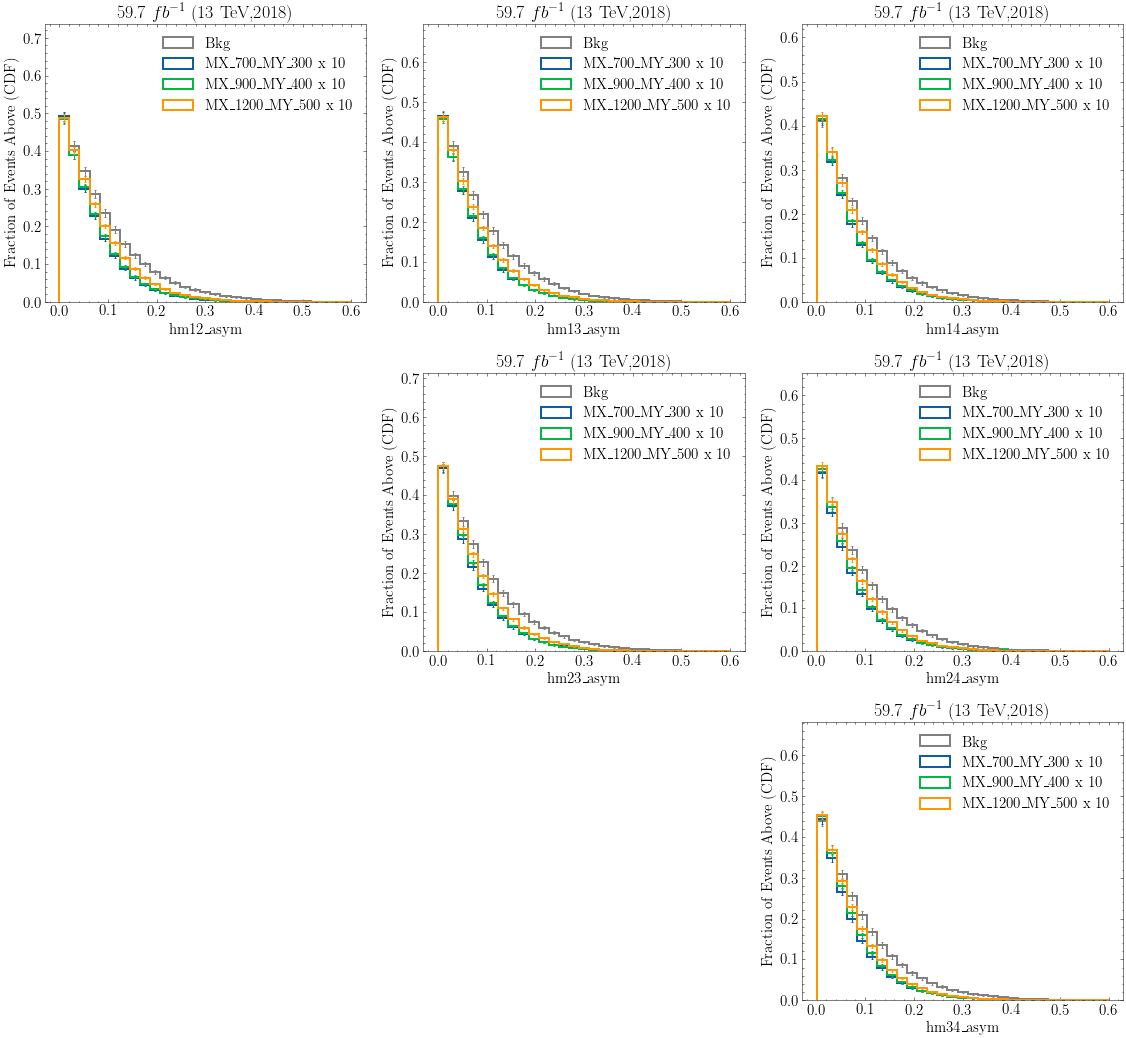

In [50]:
varinfo.higgs_m = dict(bins=np.linspace(0,500,30))

study.quick(
    bkgtrees + signaltrees[[0,4,7]],
    varlist = ["hm12_asym","hm13_asym","hm14_asym",None,"hm23_asym","hm24_asym",None,None,"hm34_asym"],
    binlist=[np.linspace(0,0.6,30)]*9,
    stacked=True,
    s_label_stat=None,
    s_xsec_scales=[None]+[10]*3,
    # log=True,
    cumulative=-1,
    density=True,
    # s_xsec_scales=bkg_rhoscales,
    dim=(-1,3),
);

In [72]:
def set_asym(tree):
    tree.extend(
        asym1 = tree.hm13_asym,
        asym2 = tree.hm24_asym,
    )
    
trees.apply(set_asym)

In [73]:
medium_4btag_filter = EventFilter("medium_4btag",filter=lambda t : ak.sum(t.jet_btag > jet_btagWP[2],axis=-1) > 3)
medium_inv_3btag_filter = EventFilter("medium_inv_3btag",filter=lambda t : ak.sum(t.jet_btag > jet_btagWP[2],axis=-1) == 3)

In [74]:
tr_trees = trees.apply(medium_4btag_filter.filter)
er_trees = trees.apply(medium_inv_3btag_filter.filter)

In [75]:
sig_asym1 = flatten(tr_trees[:-1].asym1.awkward)
sig_asym2 = flatten(tr_trees[:-1].asym2.awkward)
sig_scale = flatten(tr_trees[:-1].scale.awkward)

In [76]:
bkg_asym1 = flatten(tr_trees[[-1]].asym1.awkward)
bkg_asym2 = flatten(tr_trees[[-1]].asym2.awkward)
bkg_scale = flatten(tr_trees[[-1]].scale.awkward)

In [77]:
from scipy.optimize import fmin

sig_total = signaltrees.expected_events(None).numpy.sum()
bkg_total = bkgtrees.expected_events(None).numpy.sum()

def calc_sig_eff(center_x,center_y,radius):
    sig_radius = (sig_asym1 - center_x)**2 + (sig_asym2 - center_y)**2
    sig_mask = sig_radius < radius*radius 
    sig_eff = np.sum(sig_scale[sig_mask])/sig_total 
    return sig_eff
    
def calc_bkg_eff(center_x,center_y,radius):
    bkg_radius = (bkg_asym1 - center_x)**2 + (bkg_asym2 - center_y)**2
    bkg_mask = bkg_radius < radius*radius 
    bkg_eff = np.sum(bkg_scale[bkg_mask])/bkg_total 
    return bkg_eff

In [78]:
def find_ar(params,*args):
    sig_eff = calc_sig_eff(*params,*args)
    return -(sig_total*sig_eff)

ar_min = fmin(find_ar,[0.1,0.1],args=(0.1,))

Optimization terminated successfully.
         Current function value: -1.131351
         Iterations: 22
         Function evaluations: 44


In [79]:
print(ar_min)
calc_sig_eff(*ar_min,0.01), calc_bkg_eff(*ar_min,0.01)


[0.08679073 0.09303122]


(0.0167059736450265, 0.0011468462489662322)

In [80]:
def find_sr(params,*args):
    sig_eff = calc_sig_eff(*args,*params)
    bkg_eff = calc_bkg_eff(*args,*params)
    return bkg_eff/sig_eff

sr_min = fmin(find_sr,[0.1],args=tuple(ar_min)) 

Optimization terminated successfully.
         Current function value: 0.080608
         Iterations: 12
         Function evaluations: 27


In [81]:
print(sr_min) 

calc_sig_eff(*ar_min,*sr_min), calc_bkg_eff(*ar_min,*sr_min)

[0.08796875]


(0.6984961779803734, 0.05630421022672035)

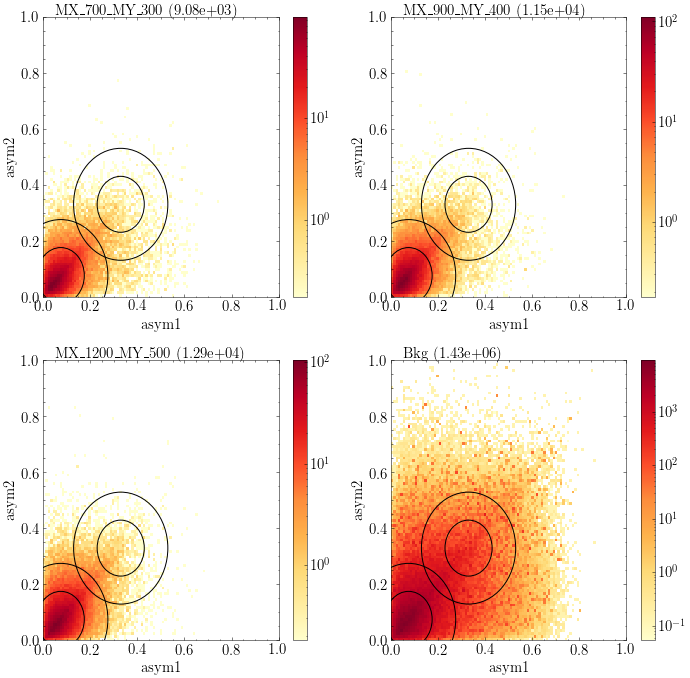

In [82]:
fig,axs = study.quick2d(
    # bkgtrees + signaltrees[[0,4,7]],
    trees[[0,4,7,-1]],
    varlist = ["asym1","asym2"],
    binlist=[np.linspace(0.,1.0,100)]*2,
    stacked=True,
    s_label_stat=None,
    s_xsec_scales=[None]+[10]*3,
    log=True,
    # log=True,
    # cumulative=-1,
    # density=True,
    # s_xsec_scales=bkg_rhoscales,
)

# ar = ar_min
ar = np.array([0.075,0.075])
sr = 0.1
# cr = 1.41*sr
cr = 2*sr
vr = ar + 1.2*(sr+cr) * ar/np.sqrt((ar**2).sum())

for ax in axs.flat: 
    
    sr_circle = plt.Circle(ar,sr,color='k',fill=None)
    ax.add_patch(sr_circle)
    cr_circle = plt.Circle(ar,cr,color='k',fill=None)
    ax.add_patch(cr_circle)
    
    
    vsr_circle = plt.Circle(vr,sr,color='k',fill=None)
    ax.add_patch(vsr_circle)
    vcr_circle = plt.Circle(vr,cr,color='k',fill=None)
    ax.add_patch(vcr_circle)
    
plt.show()

In [83]:
def hm_asym_diff(tree,ar=ar,vr=vr):
    arx,ary = ar
    vrx,vry = vr
    tree.extend(
        asym_diff= np.sqrt((tree.asym1 - arx)**2 + (tree.asym2 - ary)**2),
        asym_diff_vr= np.sqrt((tree.asym1 - vrx)**2 + (tree.asym2 - vry)**2)
    )

In [84]:
trees.apply(lambda t : hm_asym_diff(t,ar=ar,vr=vr))

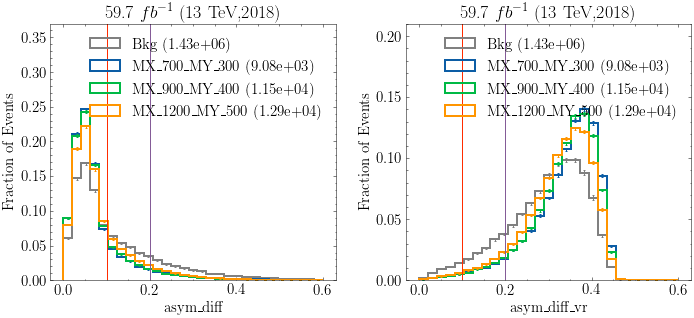

In [85]:
fig,axs = study.quick(
    bkgtrees+signaltrees[[0,4,7]],
    varlist=['asym_diff','asym_diff_vr'],
    binlist=[np.linspace(0,0.6,30)]*2,
    density=True
)

axs[0].plot([sr,sr],axs[0].get_ylim())
axs[0].plot([cr,cr],axs[0].get_ylim())


axs[1].plot([sr,sr],axs[1].get_ylim())
axs[1].plot([cr,cr],axs[1].get_ylim())

plt.show()

In [86]:
tr_trees = trees.apply(medium_4btag_filter.filter)
er_trees = trees.apply(medium_inv_3btag_filter.filter)

In [87]:
asr_filter = EventFilter('asr',asym_diff_max=sr)
acr_filter = EventFilter('acr',asym_diff_min=sr,asym_diff_max=cr)

vsr_filter = EventFilter('vsr',asym_diff_vr_max=sr)
vcr_filter = EventFilter('vcr',asym_diff_vr_min=sr,asym_diff_vr_max=cr)

In [88]:
asrt_trees = tr_trees.apply(asr_filter.filter)
asre_trees = er_trees.apply(asr_filter.filter)

acrt_trees = tr_trees.apply(acr_filter.filter)
acre_trees = er_trees.apply(acr_filter.filter)

In [89]:
vsrt_trees = tr_trees.apply(vsr_filter.filter)
vsre_trees = er_trees.apply(vsr_filter.filter)

vcrt_trees = tr_trees.apply(vcr_filter.filter)
vcre_trees = er_trees.apply(vcr_filter.filter)

In [90]:
def get_eff(region,trees=trees):
    eff = region.expected_events().numpy/trees.expected_events().numpy
    sig_eff,bkg_eff = eff[:-1],eff[-1:]
    sig_eff = get_avg_std(sig_eff)
    bkg_eff = get_avg_std(bkg_eff)
    return np.array([sig_eff,bkg_eff])

In [91]:
def get_matched_eff(region):
    region = region[:-1]
    n_all_matched = region.nfound_select.apply(lambda array : ak.sum(array == 8)).npy
    n_all = region.nfound_select.apply(lambda array : ak.count(array)).npy
    eff = n_all_matched/n_all 
    return get_avg_std(eff)

In [92]:
asrt_eff = get_eff(asrt_trees)
asre_eff = get_eff(asre_trees)

acrt_eff = get_eff(acrt_trees)
acre_eff = get_eff(acre_trees)

In [93]:
ariter = ObjIter([asrt_trees,asre_trees,acrt_trees,acre_trees])
ar_effs = ariter.apply(get_eff).numpy
ar_matched_effs = ariter.apply(get_matched_eff).numpy

In [94]:
vriter = ObjIter([vsrt_trees,vsre_trees,vcrt_trees,vcre_trees])
vr_effs = vriter.apply(get_eff).numpy
vr_matched_effs = vriter.apply(get_matched_eff).numpy

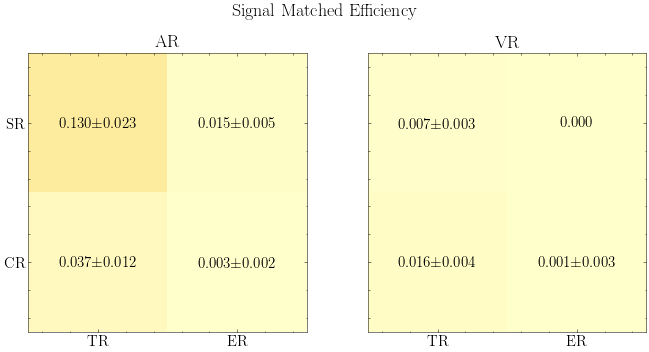

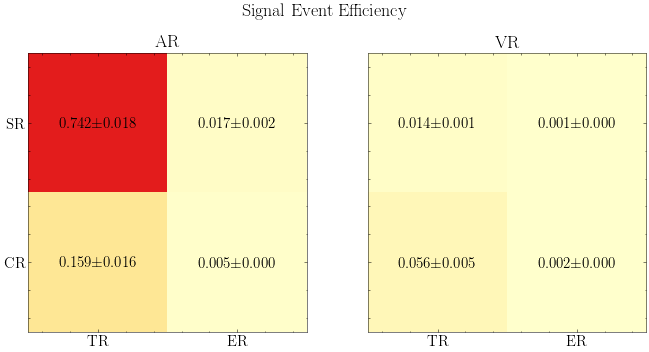

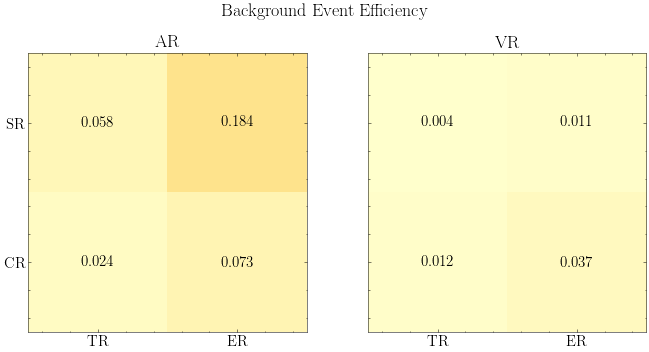

In [95]:
sig_total = signaltrees.expected_events().numpy.sum()
bkg_total = bkgtrees.expected_events().numpy.sum()

def plot_effs(effs,ax,**kwargs):
    eff = effs[:,0].reshape(2,2)
    std = effs[:,1].reshape(2,2)
    im = ax.imshow(eff,vmin=0,vmax=1,cmap='YlOrRd')
    ax.set(yticks=[0,1],yticklabels=['SR','CR'],xticks=[0,1],xticklabels=['TR','ER'],**kwargs)
    for i in range(2):
        for j in range(2):
            txt = f'{eff[j,i]:0.3f}'
            if (std[j,i] > 0): txt += f'$\pm${std[j,i]:0.3f}'
            ax.text(i,j,f'{txt}',ha="center", va="center", fontweight="bold")
            

fig,ax = plt.subplots(ncols=2,figsize=(10,5),sharey=True)
plot_effs(ar_matched_effs,ax[0],title='AR')
plot_effs(vr_matched_effs,ax[1],title='VR')
fig.suptitle('Signal Matched Efficiency')
fig.tight_layout()
            
fig,ax = plt.subplots(ncols=2,figsize=(10,5),sharey=True)
plot_effs(ar_effs[:,0],ax[0],title='AR')
plot_effs(vr_effs[:,0],ax[1],title='VR')
fig.suptitle('Signal Event Efficiency')
fig.tight_layout()

fig,ax = plt.subplots(ncols=2,figsize=(10,5),sharey=True)
plot_effs(ar_effs[:,1],ax[0],title='AR')
plot_effs(vr_effs[:,1],ax[1],title='VR')
fig.suptitle('Background Event Efficiency')
fig.tight_layout()

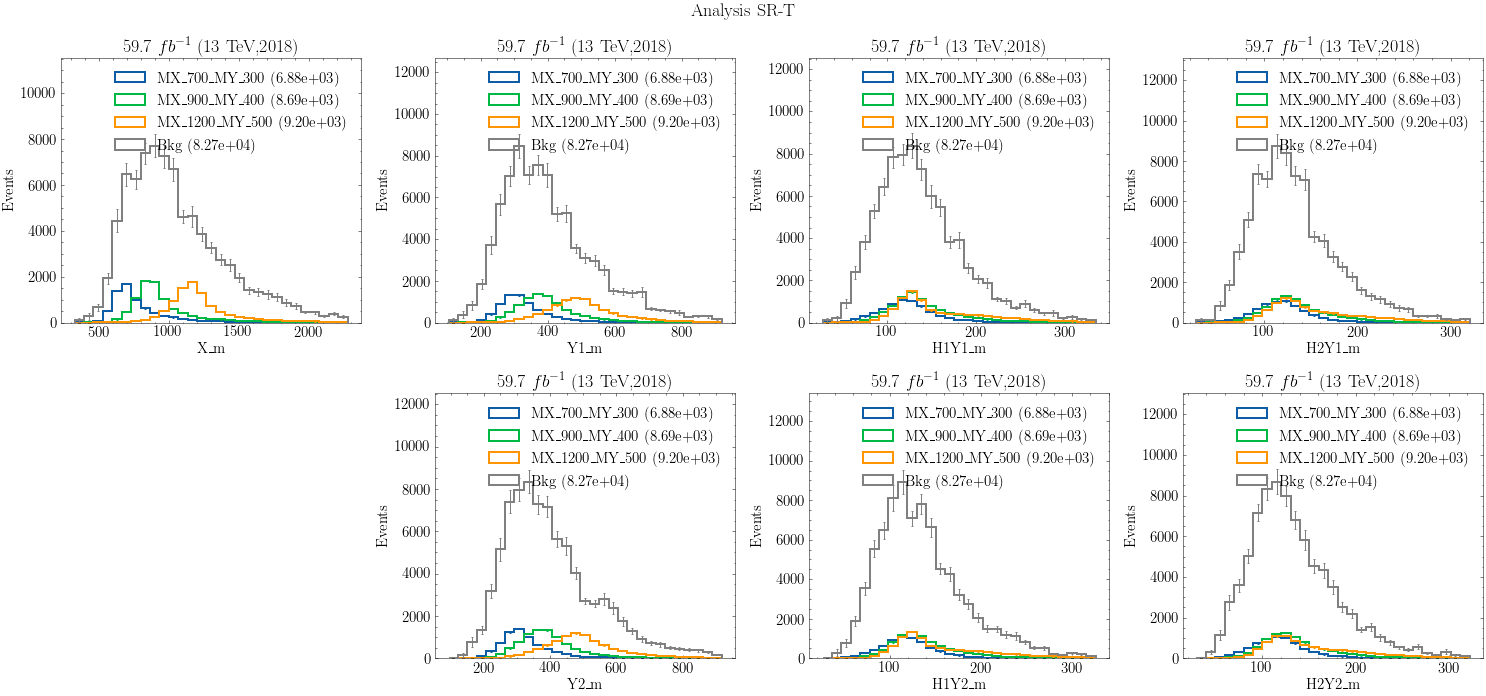

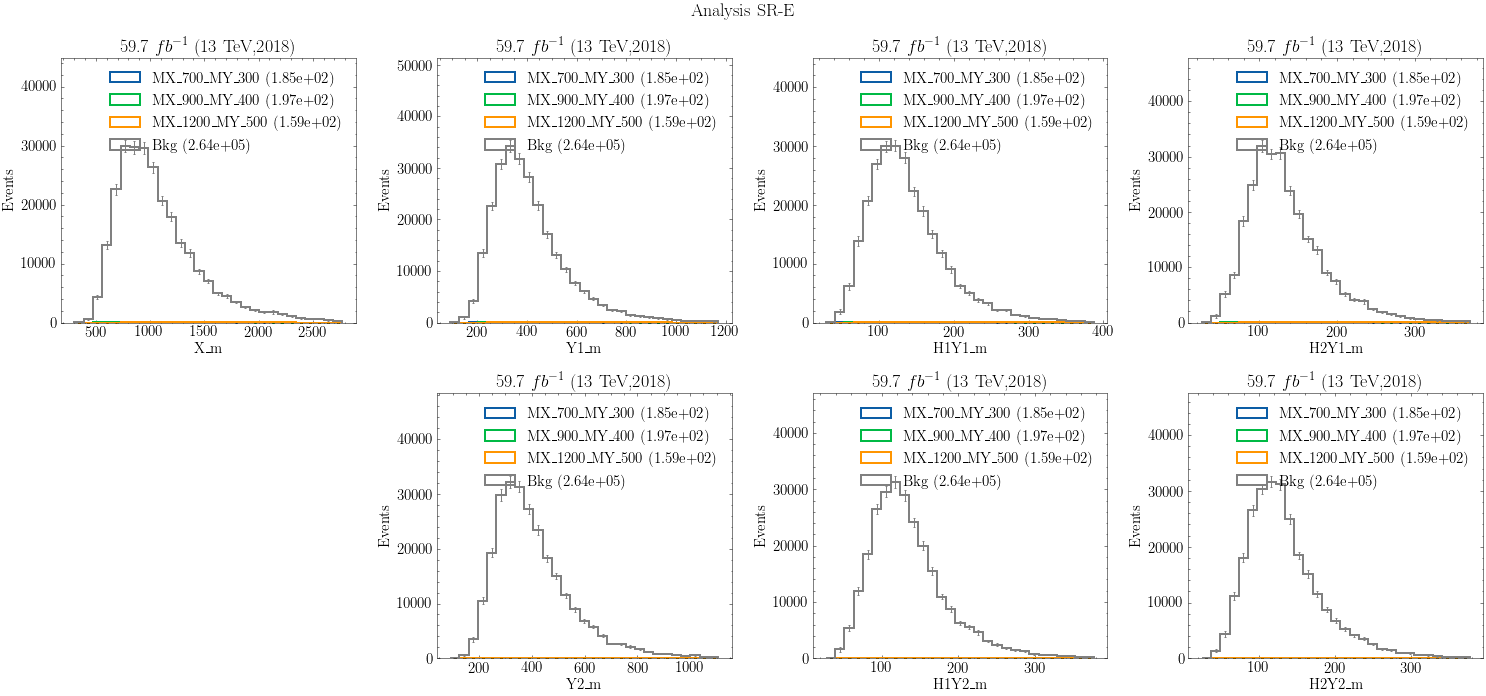

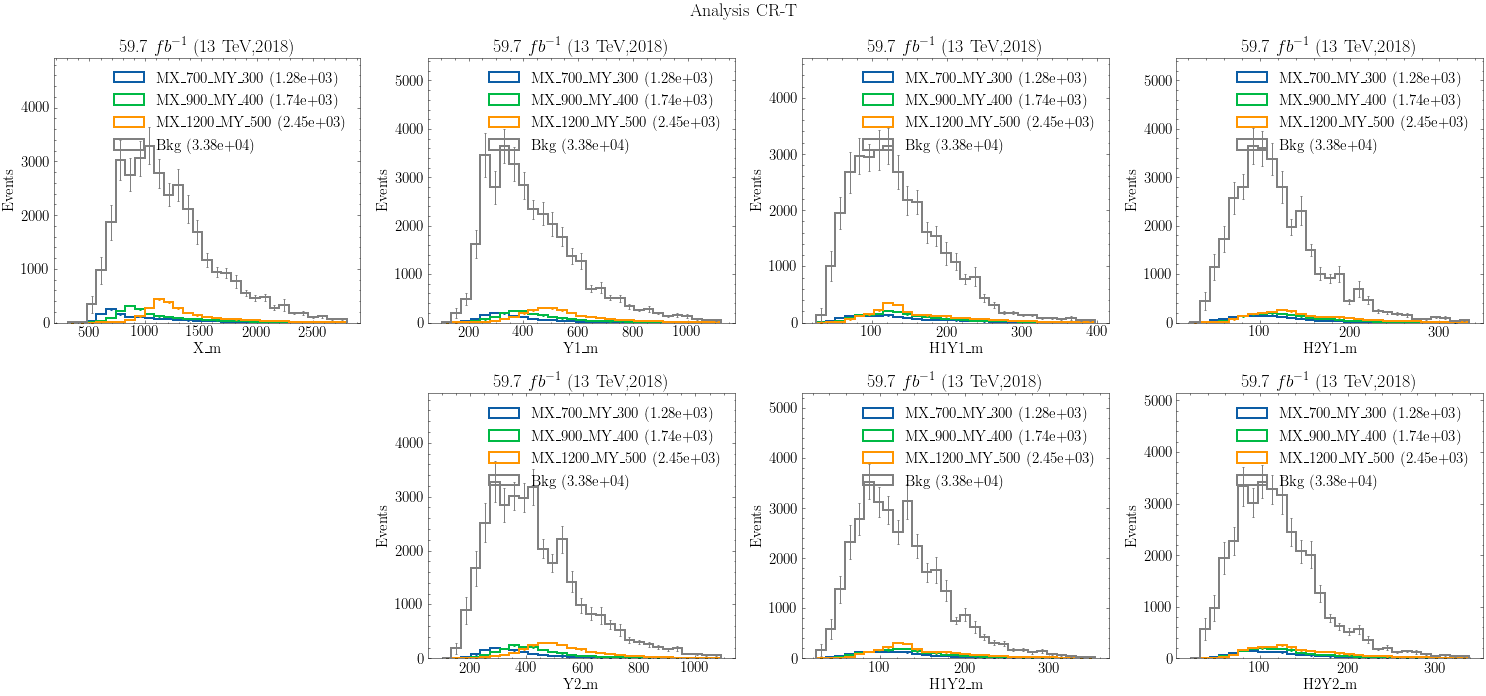

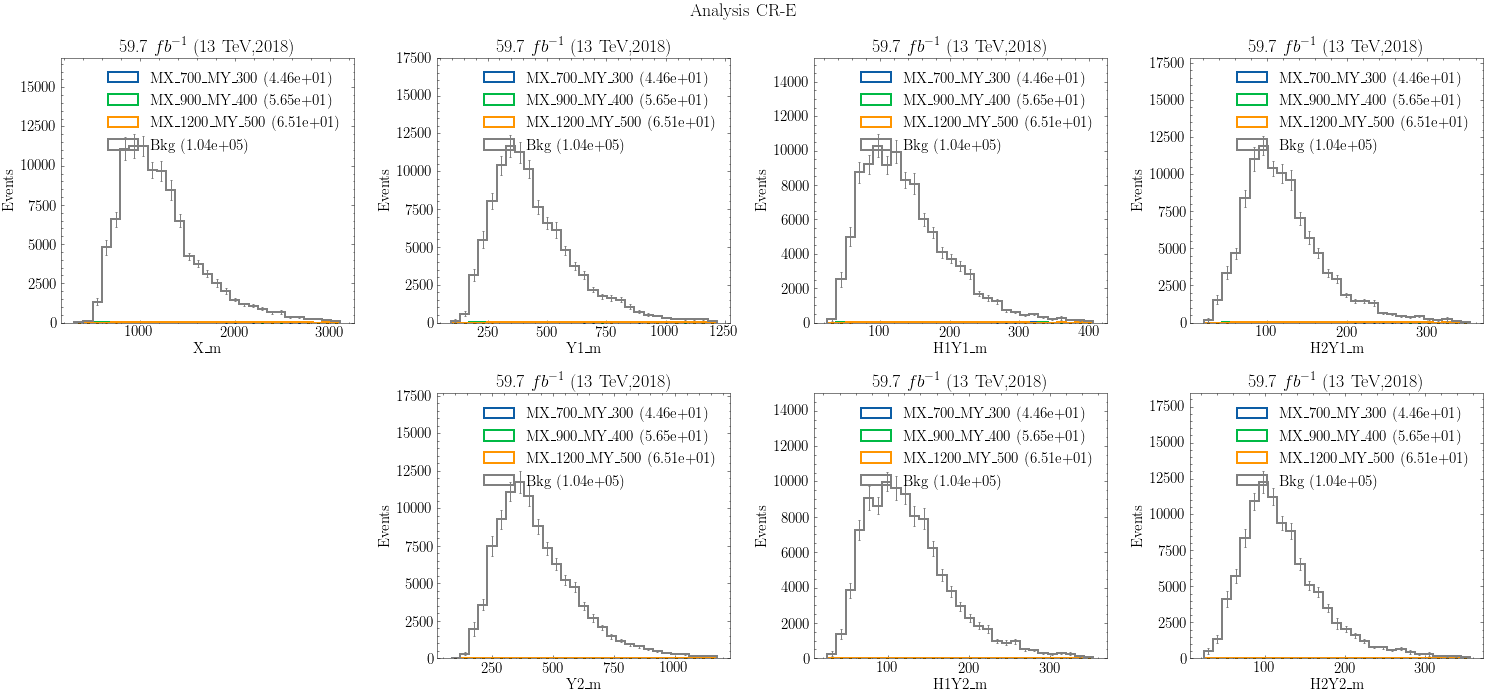

In [102]:
rnames = ['SR-T','SR-E','CR-T','CR-E']
for rname,ar_trees in zip(rnames,ariter):
    study.quick(
        ar_trees[[0,4,7,-1]],
        varlist=['X_m','Y1_m','H1Y1_m','H2Y1_m',None,'Y2_m','H1Y2_m','H2Y2_m'],
        title=f'Analysis {rname}',
        # binlist=[np.linspace(0,300,30)]
        # s_xsec_scales=[10,10,10,None],
        dim=(-1,4)
    )

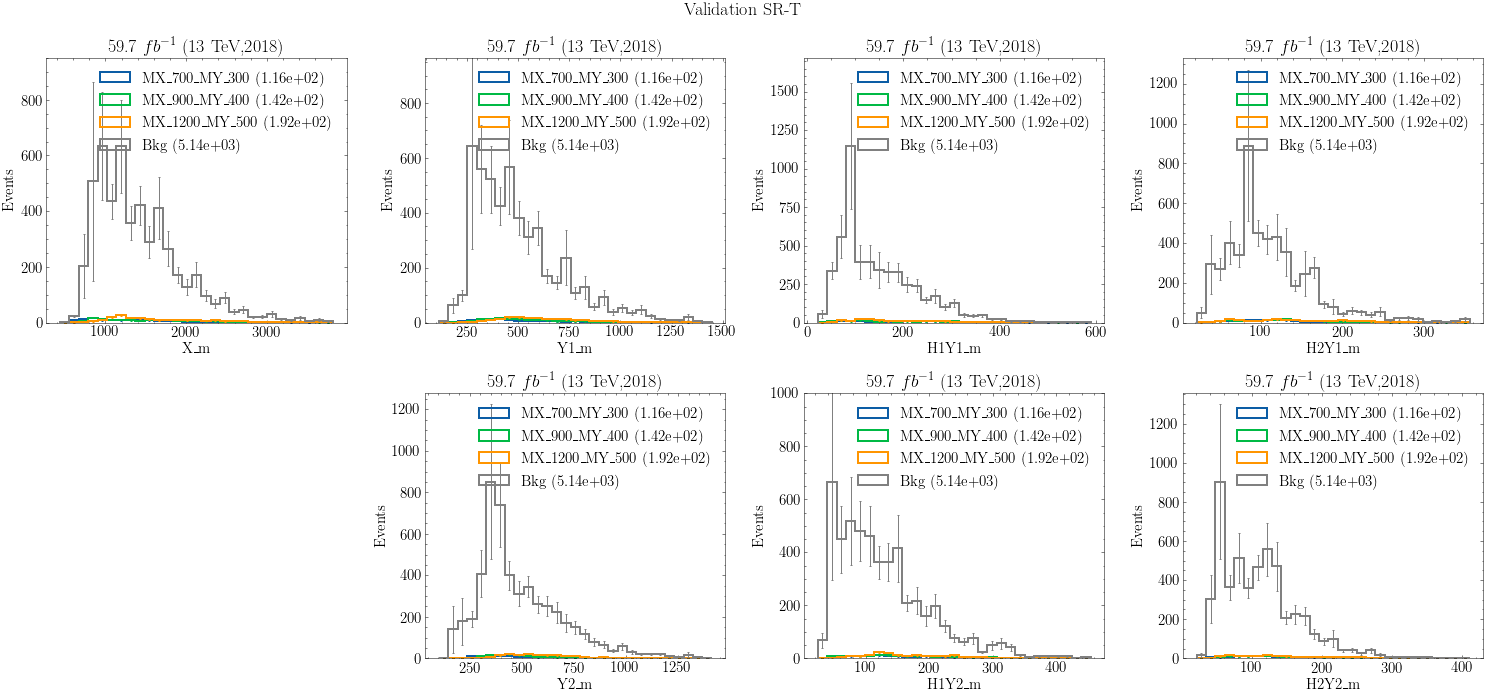

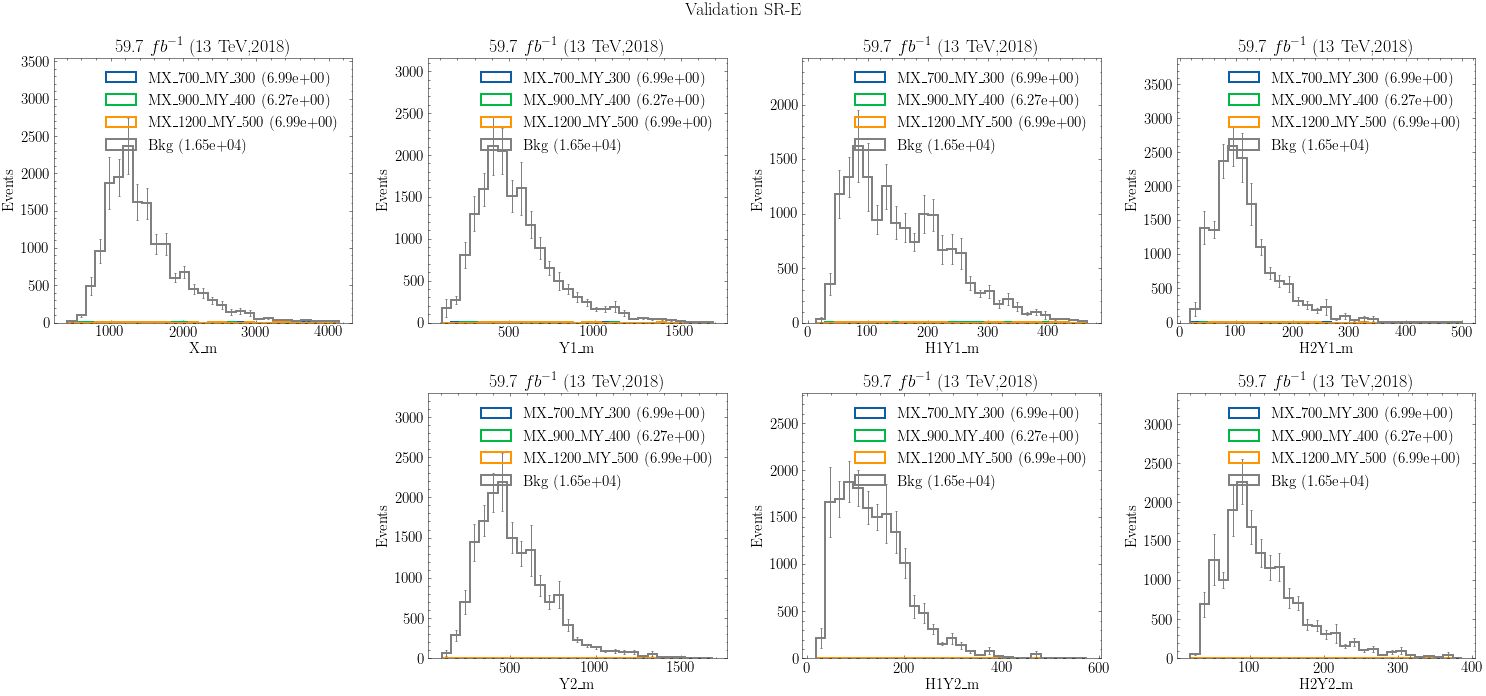

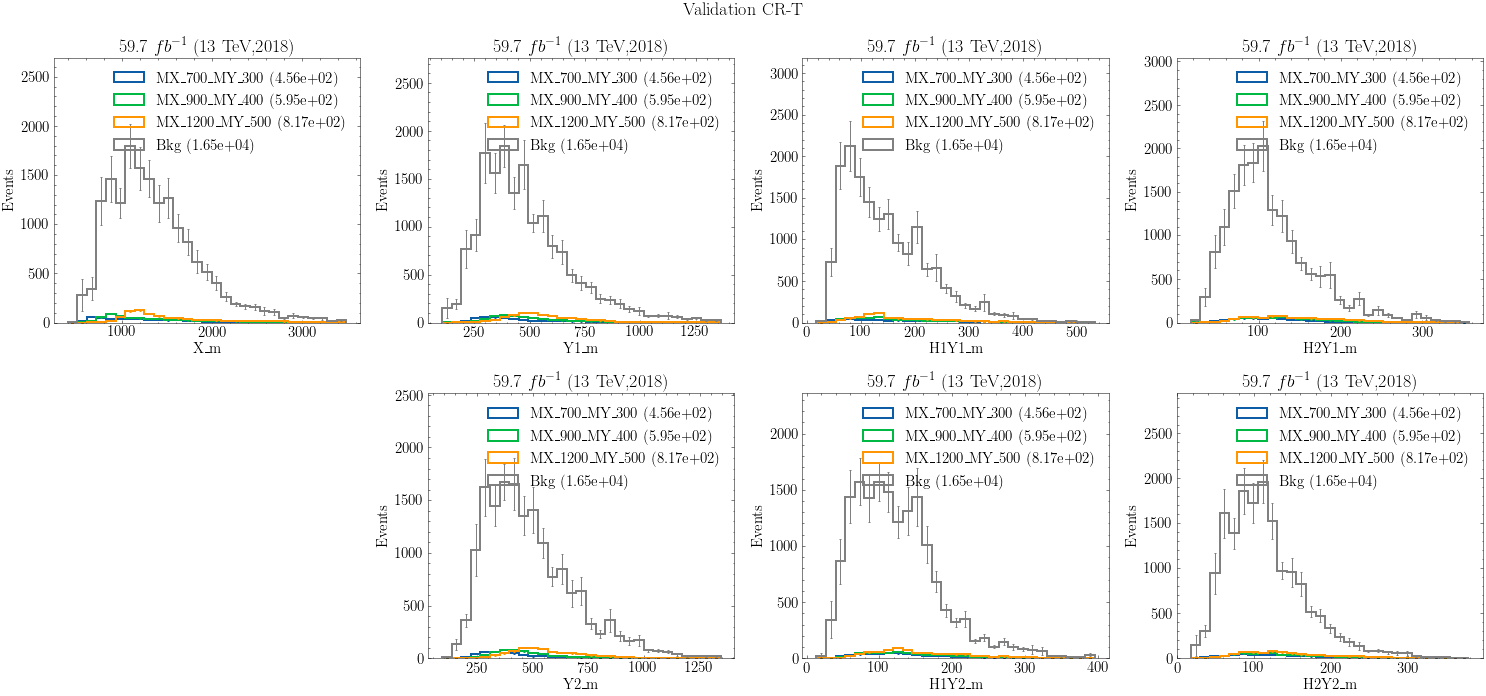

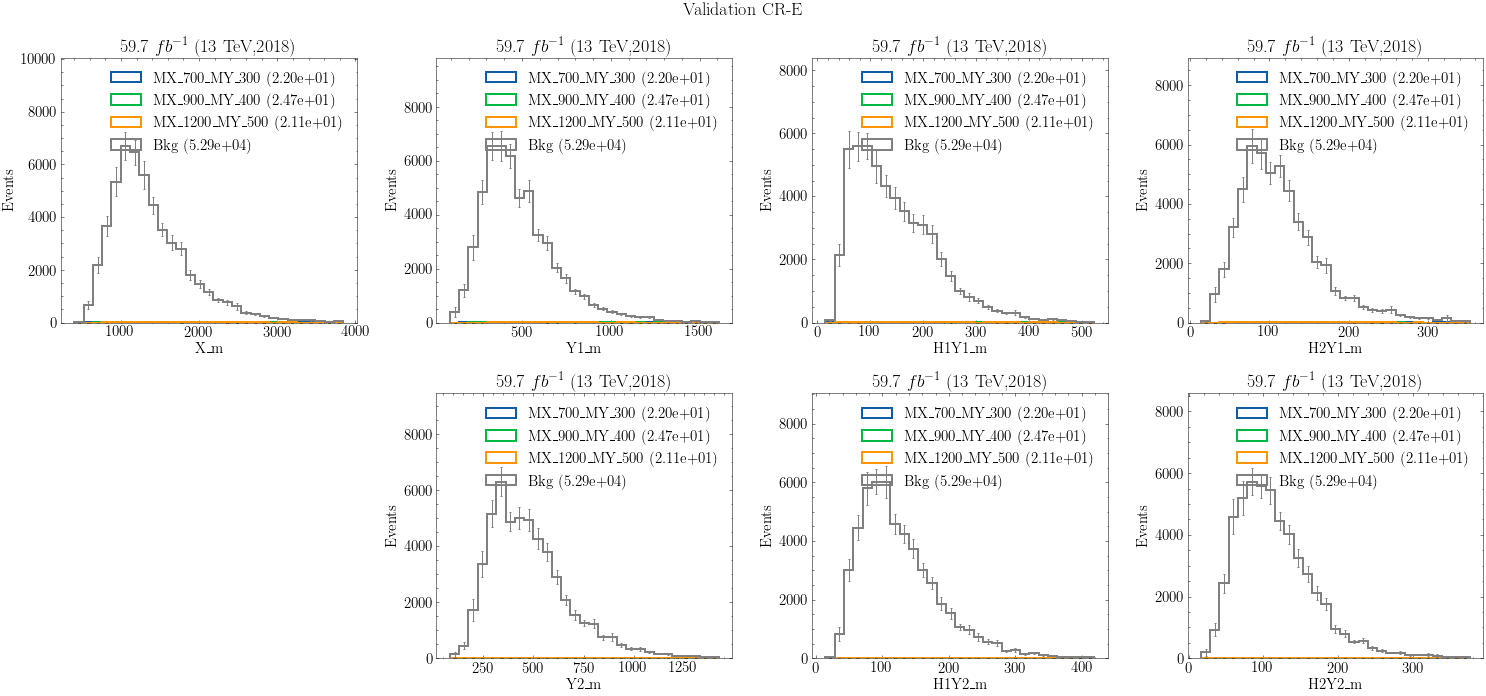

In [104]:
rnames = ['SR-T','SR-E','CR-T','CR-E']
for rname,vr_trees in zip(rnames,vriter):
    study.quick(
        vr_trees[[0,4,7,-1]],
        varlist=['X_m','Y1_m','H1Y1_m','H2Y1_m',None,'Y2_m','H1Y2_m','H2Y2_m'],
        title=f'Validation {rname}',
        # binlist=[np.linspace(0,300,30)]
        # s_xsec_scales=[10,10,10,None],
        dim=(-1,4)
    )